# Sentiment Analysis
## (TextCNN Model on Appliances dataset)

## Importing Libraries

In [256]:
import pandas as pd
from pathlib import Path
import json
import csv

In [257]:
%matplotlib inline
import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.svm import LinearSVC

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


#from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

## Fetching the dataset (Appliances)

In [258]:
df = pd.read_json (r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Appliances.json', lines=True)
df.to_csv (r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Appliances.csv', index = None)

In [259]:
#Making Dataframe
review_df = pd.read_csv(r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Appliances.csv')
review_df

C:\Users\Neha Sharma\AppData\Local\Temp\ipykernel_8488\2941876761.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_df = pd.read_csv(r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Appliances.csv')


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
602772,5,NaN,True,"08 10, 2017",A24A9P4F2SLTK5,B01HJH2PY0,NaN,Tana,perfect replacement for our broken one.,Five Stars,1502323200,NaN
602773,2,NaN,True,"08 1, 2018",A2JCB4KHBWEELW,B01HJHHEA0,NaN,CMA,"Quick delivery, did not fit my stove.",Two Stars,1533081600,NaN
602774,5,NaN,True,"04 13, 2018",A1LDYYVTLPP2Z5,B01HJHHEA0,NaN,Himmy,Perfect match for my oven!,Five Stars,1523577600,NaN
602775,1,NaN,True,"03 23, 2018",AP1M5O06IOYZ7,B01HJH92JQ,NaN,Alberto,Doesn't work with Bosch SHX33A06UC/14 dishwash...,Doesn't work with Bosch SHX33A06UC/14 dishwash...,1521763200,NaN


In [264]:
#Coulmns in dataset
review_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')

## Data Cleaning

In [265]:
#Dropping the columns not required
review_df=review_df.drop(['vote','verified','reviewTime','style','reviewerName', 'unixReviewTime', 'image'],axis=1)

In [267]:
type(review_df['reviewText'][0])

str

<AxesSubplot: xlabel='overall', ylabel='count'>

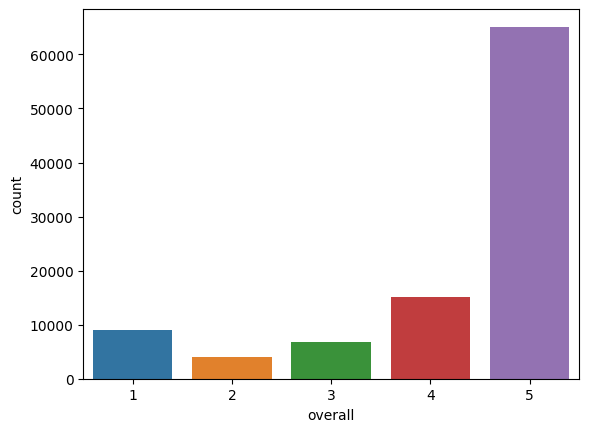

In [268]:
#Count of overall rating
sbn.countplot(x=review_df['overall'])

In [269]:
#Removing Stopwords
def data_clean( rev, remove_stopwords=True): 

    new_text = re.sub("[^a-zA-Z]"," ", rev)
   
    words = new_text.lower().split()
    
    if remove_stopwords:
        sts = set(stopwords.words("english"))
        words = [w for w in words if not w in sts]
    ary=[]
    eng_stemmer = english_stemmer 
    for word in words:
        ary.append(eng_stemmer.stem(word))

    
    return(ary)

In [270]:
cleaned_reviewData = []
for rev in review_df['reviewText']:
    #print(rev)
    cleaned_reviewData.append(" ".join(data_clean(str(rev))))
    
clean_summaryData = []
for rev in review_df['summary']:
    clean_summaryData.append(" ".join(data_clean(str(rev))))

In [271]:
#Fetching most frequent words from Review Text
Most_used_Words_Review =pd.Series(' '.join(cleaned_reviewData).lower().split()).value_counts()[:20]
print (Most_used_Words_Review)

work       37458
use        27330
one        25917
great      23423
filter     22633
dryer      19458
product    18438
fit        17997
vent       17267
clean      16444
water      16345
time       16002
good       15886
get        15312
replac     14667
need       14512
like       13927
well       13921
would      13766
perfect    13005
dtype: int64


In [272]:
#Fetching most frequent words from Review Summary
Most_used_Words_Summary = pd.Series(' '.join(clean_summaryData).lower().split()).value_counts()[:20]
print (Most_used_Words_Summary)

star       28796
five       21110
great      10925
work        9492
good        6866
product     5080
filter      4875
four        4019
perfect     3868
fit         3832
price       2784
one         2720
replac      2666
easi        2510
well        2229
water       2206
dryer       2058
need        2055
like        1888
use         1850
dtype: int64


## Data Classification and Clustering

In [273]:
#preparing matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
text_vectorizer = TfidfVectorizer(min_df=4, max_features = 1000)
test_vector = text_vectorizer.fit_transform(cleaned_reviewData)
tfidf_vector = dict(zip(text_vectorizer.get_feature_names_out(), text_vectorizer.idf_))

In [274]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Neha
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [275]:
# Sentiment Analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
sample_review = review_df.reviewText[:10]
for test in sample_review:
    test
    ss = analyser.polarity_scores(test)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
    print(test)

compound: 0.9836, 
neg: 0.0, 
neu: 0.771, 
pos: 0.229, 
Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.

Alan Gregerman discusses the meaning of human interactions and the kinds of situations that tend to inspire original and/or clear thinking that leads to innovation. These things include how people communicate in certain situations such as when they are outside of their normal patterns.

Gregerman identifies the ingredients that make innovation more likely. This includes people being compelled to interact when they normally wouldn't, leading to serendipity. Sometimes the phenomenon will occur through collaboration, and sometimes by chance such as when an individual is away from home on travel.

I recommend this book for its common sense, its truth and the apparent mastery of the subject by the author.
compound: 0.9925, 
neg: 0.017, 
neu: 0.793, 
pos: 0.189, 
I have enjoyed Dr. Al

In [276]:
#Kmeans clusters
from sklearn.cluster import MiniBatchKMeans

clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmodel = kmeans_model.fit(test_vector)
kmodel_clusters = kmodel.predict(test_vector)
kmodel_distances = kmodel.transform(test_vector)
centroids = kmodel.cluster_centers_.argsort()[:, ::-1]
values = text_vectorizer.get_feature_names_out()
for i in range(clusters):
    print("Cluster %d:" % i)
    for j in centroids[i, :5]:
        print(' %s' % values[j])
    print()

Cluster 0:
 exact
 expect
 nice
 describ
 ok

Cluster 1:
 great
 product
 price
 fit
 look

Cluster 2:
 well
 work
 fit
 humidifi
 made

Cluster 3:
 advertis
 work
 exact
 product
 fit

Cluster 4:
 filter
 one
 use
 work
 water

Cluster 5:
 good
 work
 fit
 filter
 replac

Cluster 6:
 perfect
 fit
 work
 replac
 great

Cluster 7:
 work
 fine
 great
 expect
 well

Cluster 8:
 great
 work
 fit
 look
 price

Cluster 9:
 good
 price
 product
 qualiti
 work

Cluster 10:
 piec
 ice
 poor
 design
 plastic

Cluster 11:
 fit
 stove
 look
 like
 work

Cluster 12:
 love
 great
 work
 perfect
 look

Cluster 13:
 front
 smoke
 bright
 outlet
 face

Cluster 14:
 easi
 instal
 great
 work
 perfect

Cluster 15:
 perfect
 work
 replac
 need
 product

Cluster 16:
 excel
 product
 price
 qualiti
 work

Cluster 17:
 fit
 perfect
 work
 great
 humidifi

Cluster 18:
 thank
 great
 work
 perfect
 need

Cluster 19:
 job
 good
 great
 done
 well



In [277]:
test_reviewText = review_df.reviewText
test_Ratings = review_df.overall
text_vectorizer = TfidfVectorizer(max_df=.8)
text_vectorizer.fit_transform(test_reviewText.values.astype('U'))
def rate(r):
    ary2 = []
    for rating in r:
        tv = [0,0,0,0,0]
        tv[rating-1] = 1
        ary2.append(tv)
    return np.array(ary2)

In [278]:
#Review text
test_reviewText =test_reviewText[:2000]
test_reviewText

0       Not one thing in this book seemed an obvious o...
1       I have enjoyed Dr. Alan Gregerman's weekly blo...
2       Alan Gregerman believes that innovation comes ...
3       Alan Gregerman is a smart, funny, entertaining...
4       As I began to read this book, I was again remi...
                              ...                        
1995     Can be painted.  Keeps out rodents and cold air.
1996    this thing really works. it stopped the cold a...
1997    This thing is well worth the money when you co...
1998                                  everything was fine
1999    Great product. It is a replacement for one we ...
Name: reviewText, Length: 2000, dtype: object

In [279]:
#Overall ratings
test_Ratings = test_Ratings[:2000]
test_Ratings

0       5
1       5
2       5
3       5
4       5
       ..
1995    5
1996    5
1997    5
1998    5
1999    5
Name: overall, Length: 2000, dtype: int64

In [280]:
X = text_vectorizer.transform(test_reviewText.values.astype('U')).toarray()
y = rate(test_Ratings.values)

## TextCNN Model

In [281]:
#TextCNN Model
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)

#After performing Oversampling (because of high amount of data in with 5 Rating)
over = SMOTE(k_neighbors=3)
X_train, y_train = over.fit_resample(X_train, y_train)

#model implementation
model = Sequential()
model.add(Dense(128,input_dim=X_train.shape[1]))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
map=model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10,batch_size=32,verbose=1)
model.evaluate(X_test,y_test)[1]

Epoch 1/10
57/57 [==============================] - 7s 98ms/step - loss: 1.2699 - accuracy: 0.5706 - val_loss: 1.1590 - val_accuracy: 0.5700
Epoch 2/10
57/57 [==============================] - 5s 83ms/step - loss: 1.0253 - accuracy: 0.5833 - val_loss: 1.0674 - val_accuracy: 0.5750
Epoch 3/10
57/57 [==============================] - 5s 89ms/step - loss: 0.8858 - accuracy: 0.6417 - val_loss: 1.0103 - val_accuracy: 0.5850
Epoch 4/10
57/57 [==============================] - 5s 80ms/step - loss: 0.7730 - accuracy: 0.7283 - val_loss: 0.9753 - val_accuracy: 0.6300
Epoch 5/10
57/57 [==============================] - 5s 88ms/step - loss: 0.6758 - accuracy: 0.7822 - val_loss: 0.9543 - val_accuracy: 0.6400
Epoch 6/10
57/57 [==============================] - 4s 69ms/step - loss: 0.5878 - accuracy: 0.8283 - val_loss: 0.9456 - val_accuracy: 0.6500
Epoch 7/10
57/57 [==============================] - 4s 67ms/step - loss: 0.5096 - accuracy: 0.8678 - val_loss: 0.9570 - val_accuracy: 0.6300
Epoch 8/10
57

0.6449999809265137

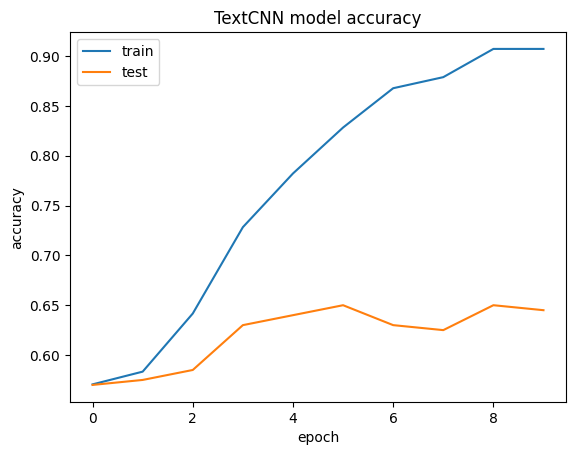

In [282]:
#TextCNN model accuracy graph
plt.plot(map.history['accuracy'])
plt.plot(map.history['val_accuracy'])
plt.title('TextCNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

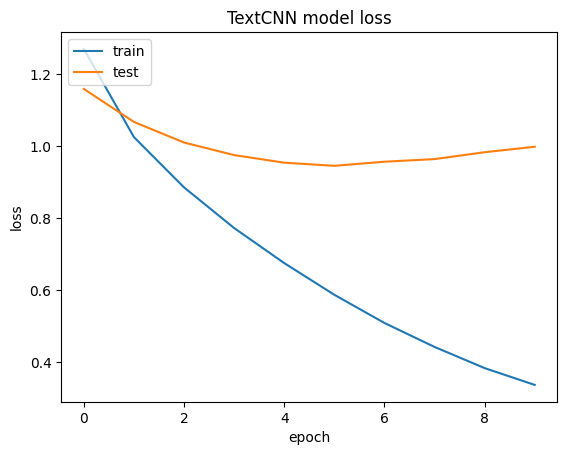

In [283]:
#TextCNN model Loss graph
plt.plot(map.history['loss'])
plt.plot(map.history['val_loss'])
plt.title('TextCNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()